# Fine-tuning MobileNetV3 for Pet Emotion Classification

This notebook fine-tunes a pretrained MobileNetV3 model on two pet emotion datasets to classify emotions: **happy**, **sad**, and **angry**.

## Datasets:
1. Dog Emotion Dataset (4000 images)
2. Pet's Facial Expression Dataset (1000 images)

We'll combine both datasets and focus only on the three target emotions.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preparation

First, let's load both datasets and combine them for training.

In [ ]:
DOG_EMOTION_PATH = "/kaggle/input/dog-emotion/Dog Emotion"
PET_EXPRESSION_PATH = "/kaggle/input/pets-facial-expression-dataset"

COMBINED_DATA_PATH = "/kaggle/working/combined_pet_emotions"
os.makedirs(COMBINED_DATA_PATH, exist_ok=True)

emotions = ["happy", "sad", "angry"]
for emotion in emotions:
    os.makedirs(os.path.join(COMBINED_DATA_PATH, emotion), exist_ok=True)

print("Created directories for combined dataset")

Created directories for combined dataset


In [ ]:
def copy_images_to_combined_dataset():
    image_count = 0

    print("Processing Dog Emotion dataset...")
    for emotion in emotions:
        source_dir = os.path.join(DOG_EMOTION_PATH, emotion)
        target_dir = os.path.join(COMBINED_DATA_PATH, emotion)

        if os.path.exists(source_dir):
            for img_file in os.listdir(source_dir):
                if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                    source_path = os.path.join(source_dir, img_file)
                    target_path = os.path.join(target_dir, f"dog_{img_file}")
                    shutil.copy2(source_path, target_path)
                    image_count += 1

    print("Processing Pet Expression dataset...")
    emotion_mapping = {"Happy": "happy", "Sad": "sad", "Angry": "angry"}

    for source_emotion, target_emotion in emotion_mapping.items():
        source_dir = os.path.join(PET_EXPRESSION_PATH, source_emotion)
        target_dir = os.path.join(COMBINED_DATA_PATH, target_emotion)

        if os.path.exists(source_dir):
            for img_file in os.listdir(source_dir):
                if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                    source_path = os.path.join(source_dir, img_file)
                    target_path = os.path.join(target_dir, f"pet_{img_file}")
                    shutil.copy2(source_path, target_path)
                    image_count += 1

    return image_count


total_images = copy_images_to_combined_dataset()
print(f"Total images copied: {total_images}")

for emotion in emotions:
    emotion_dir = os.path.join(COMBINED_DATA_PATH, emotion)
    count = len(
        [
            f
            for f in os.listdir(emotion_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
    )
    print(f"{emotion}: {count} images")

Processing Dog Emotion dataset...
Processing Pet Expression dataset...
Total images copied: 3500
happy: 1000 images
sad: 1250 images
angry: 1250 images


## Data Transforms and Dataset Setup

Define data augmentation and normalization transforms for training and validation.

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.RandomRotation(degrees=30),
        transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10
        ),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

full_dataset = ImageFolder(root=COMBINED_DATA_PATH, transform=train_transforms)
print(f"Total dataset size: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Class to index mapping: {full_dataset.class_to_idx}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transforms

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Total dataset size: 3500
Classes: ['angry', 'happy', 'sad']
Class to index mapping: {'angry': 0, 'happy': 1, 'sad': 2}
Train dataset size: 2800
Validation dataset size: 700


In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 88
Number of validation batches: 22


## Model Setup

Load the pretrained MobileNetV3 model and modify it for our 3-class classification task.

In [ ]:
model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=3)

layer_count = len(list(model.named_parameters()))
print(f"Total layers in model: {layer_count}")

unfreeze_after = int(layer_count * 0.7)  # Keep first 70% frozen
print(f"Unfreezing layers after index: {unfreeze_after}")

for i, (name, param) in enumerate(model.named_parameters()):
    if i < unfreeze_after:  # Freeze early layers
        param.requires_grad = False
    else:  # Unfreeze later layers
        param.requires_grad = True

classifier_in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(classifier_in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),  # Reduced dropout
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 3),  # Final classification layer
)

model = model.to(device)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(
    f"Percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%"
)

print("\nFirst 5 trainable layers:")
trainable_layers = [
    (name, param.shape)
    for name, param in model.named_parameters()
    if param.requires_grad
]
for name, shape in trainable_layers[:5]:
    print(f"  {name}: {shape}")

print("\nLast 5 trainable layers:")
for name, shape in trainable_layers[-5:]:
    print(f"  {name}: {shape}")

print(f"\nTotal trainable layers: {len(trainable_layers)}")

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Model loaded successfully!
Model device: cuda:0
Total parameters: 4,205,875
Trainable parameters: 4,205,875


In [ ]:
num_epochs = 25  # Increased epochs
learning_rate = 0.001  # Slightly increased learning rate
weight_decay = 5e-4  # Adjusted weight decay
max_grad_norm = 1.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=learning_rate,
    weight_decay=weight_decay,
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.2, patience=4, verbose=True
)

print("Training setup complete!")
print(f"Number of epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Batch size: {batch_size}")
print(f"Gradient clipping max norm: {max_grad_norm}")

Training setup complete!
Number of epochs: 20
Learning rate: 0.001
Batch size: 32


## Training Loop

Train the model with validation monitoring.

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    max_grad_norm=1.0,
):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    grad_norms = []

    best_val_acc = 0.0
    best_model_state = None
    patience = 7  # Increased patience for early stopping
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 60)

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        epoch_grad_norms = []

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), max_grad_norm
            )
            epoch_grad_norms.append(grad_norm.item())

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if (batch_idx + 1) % 50 == 0:
                print(
                    f"Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Grad Norm: {grad_norm:.4f}"
                )

        train_acc = 100 * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        avg_grad_norm = np.mean(epoch_grad_norms)
        grad_norms.append(avg_grad_norm)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(
            f"    Best Val Acc: {best_val_acc:.2f}%, Avg Grad Norm: {avg_grad_norm:.4f}"
        )
        if epochs_no_improve > 0:
            print(f"    Epochs without improvement: {epochs_no_improve}/{patience}")

        scheduler.step(val_acc)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "grad_norms": grad_norms,
        "best_model_state": best_model_state,
        "best_val_acc": best_val_acc,
    }


# Start training
print("Starting training...")
training_results = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    max_grad_norm,
)
print(
    f"\nTraining completed! Best validation accuracy: {training_results['best_val_acc']:.2f}%"
)

Starting training...

Epoch 1/20
------------------------------------------------------------
Batch [50/88], Loss: 1.0474
Train Loss: 1.5498, Train Acc: 72.32%
Val Loss: 0.8546, Val Acc: 78.57%
Best Val Acc: 78.57%

Epoch 2/20
------------------------------------------------------------
Batch [50/88], Loss: 0.3101
Train Loss: 0.4057, Train Acc: 88.39%
Val Loss: 0.8881, Val Acc: 80.71%
Best Val Acc: 80.71%

Epoch 3/20
------------------------------------------------------------
Batch [50/88], Loss: 0.1433
Train Loss: 0.1984, Train Acc: 94.00%
Val Loss: 0.6635, Val Acc: 84.71%
Best Val Acc: 84.71%

Epoch 4/20
------------------------------------------------------------
Batch [50/88], Loss: 0.0942
Train Loss: 0.1471, Train Acc: 95.39%
Val Loss: 0.6839, Val Acc: 85.57%
Best Val Acc: 85.57%

Epoch 5/20
------------------------------------------------------------
Batch [50/88], Loss: 0.0361
Train Loss: 0.1233, Train Acc: 95.82%
Val Loss: 0.7854, Val Acc: 84.86%
Best Val Acc: 85.57%

Epoch 6/

## Training Results Visualization

Plot training and validation metrics.

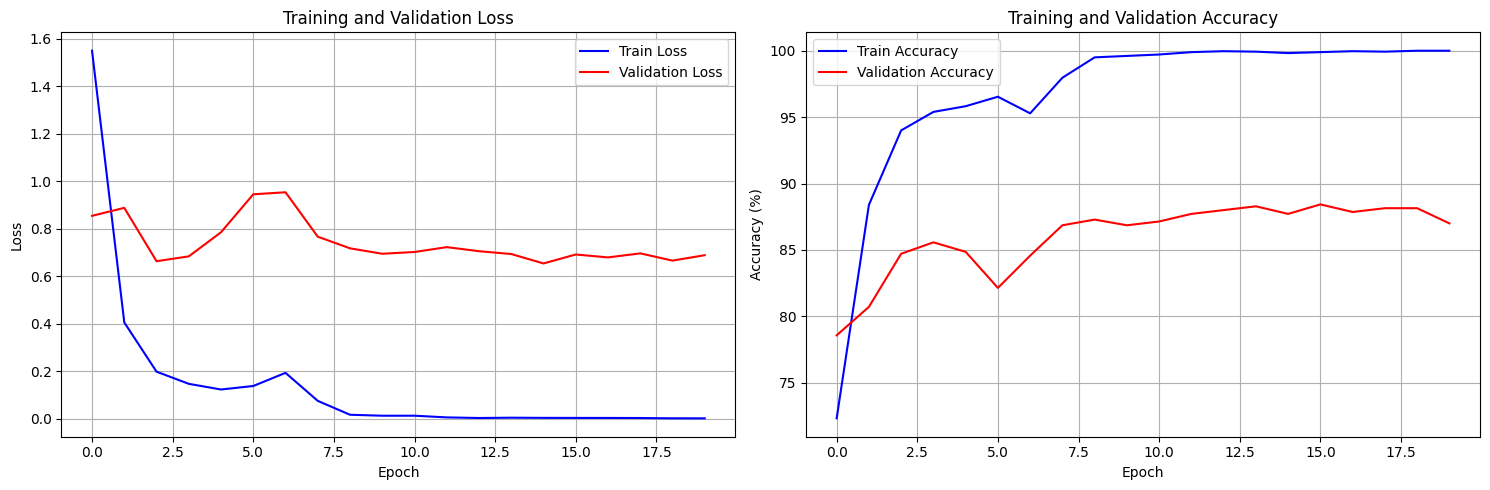

Final Train Accuracy: 100.00%
Final Validation Accuracy: 87.00%
Best Validation Accuracy: 88.43%


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(training_results["train_losses"], label="Train Loss", color="blue")
ax1.plot(training_results["val_losses"], label="Validation Loss", color="red")
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(training_results["train_accuracies"], label="Train Accuracy", color="blue")
ax2.plot(training_results["val_accuracies"], label="Validation Accuracy", color="red")
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.grid(True)

ax3.plot(training_results["grad_norms"], label="Gradient Norm", color="green")
ax3.axhline(
    y=max_grad_norm,
    color="red",
    linestyle="--",
    label=f"Clipping Threshold ({max_grad_norm})",
)
ax3.set_title("Average Gradient Norm per Epoch")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Gradient Norm")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Train Accuracy: {training_results['train_accuracies'][-1]:.2f}%")
print(f"Final Validation Accuracy: {training_results['val_accuracies'][-1]:.2f}%")
print(f"Best Validation Accuracy: {training_results['best_val_acc']:.2f}%")
print(f"Final Average Gradient Norm: {training_results['grad_norms'][-1]:.4f}")

## Model Evaluation

Load the best model and evaluate on validation set with detailed metrics.

Classification Report:
              precision    recall  f1-score   support

       angry       0.85      0.82      0.84       262
       happy       0.89      0.84      0.86       195
         sad       0.87      0.95      0.91       243

    accuracy                           0.87       700
   macro avg       0.87      0.87      0.87       700
weighted avg       0.87      0.87      0.87       700



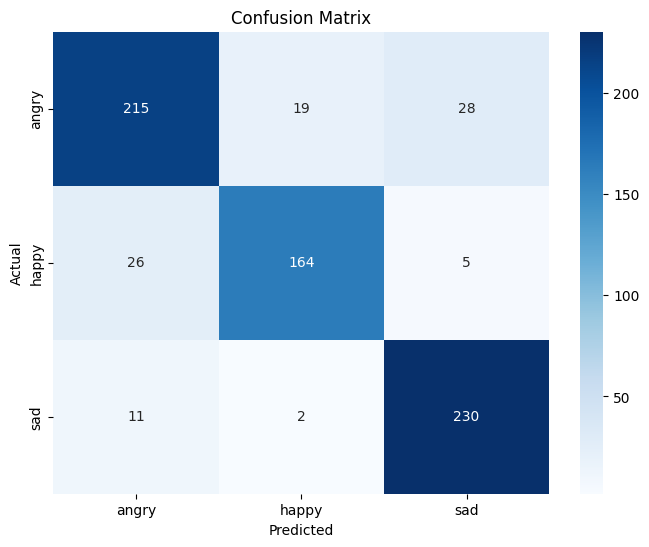

In [ ]:
model.load_state_dict(training_results["best_model_state"])
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

class_names = ["angry", "happy", "sad"]
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Save the Model

Save the trained model for future use.

In [ ]:
model_dir = "/kaggle/working/pet_emotion_model"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "mobilenetv3_pet_emotion_classifier.pth")
torch.save(
    {
        "model_state_dict": training_results["best_model_state"],
        "model_architecture": "mobilenetv3_large_100",
        "num_classes": 3,
        "class_names": class_names,
        "class_to_idx": full_dataset.class_to_idx,
        "best_val_acc": training_results["best_val_acc"],
        "train_transforms": str(train_transforms),
        "val_transforms": str(val_transforms),
        "custom_classifier": True,  # Flag indicating we used a custom classifier
        "classifier_config": {
            "input_size": model.classifier[0].in_features,
            "hidden_sizes": [256, 128],
            "dropout": 0.3,
        },
    },
    model_path,
)

config_path = os.path.join(model_dir, "model_config.txt")
with open(config_path, "w") as f:
    f.write("Model: MobileNetV3 Large 100\n")
    f.write("Number of classes: 3\n")
    f.write(f"Class names: {class_names}\n")
    f.write(f"Class to index mapping: {full_dataset.class_to_idx}\n")
    f.write(f"Best validation accuracy: {training_results['best_val_acc']:.2f}%\n")
    f.write(f"Total training images: {len(train_dataset)}\n")
    f.write(f"Total validation images: {len(val_dataset)}\n")
    f.write(f"Training epochs: {num_epochs}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Learning rate: {learning_rate}\n")
    f.write("Custom classifier: Yes (3-layer MLP with BatchNorm)\n")

print(f"Model saved successfully to: {model_path}")
print(f"Model configuration saved to: {config_path}")

print("\nSaved files:")
for file in os.listdir(model_dir):
    file_path = os.path.join(model_dir, file)
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
    print(f"  {file}: {file_size:.2f} MB")

Model saved successfully to: /kaggle/working/pet_emotion_model/mobilenetv3_pet_emotion_classifier.pth
Model configuration saved to: /kaggle/working/pet_emotion_model/model_config.txt

Saved files:
  model_config.txt: 0.00 MB
  mobilenetv3_pet_emotion_classifier.pth: 16.24 MB


## Model Loading Example

Example of how to load and use the saved model for inference.

In [ ]:
def load_trained_model(model_path):
    """Load the trained model for inference"""
    checkpoint = torch.load(model_path, map_location=device)

    model = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=3)

    classifier_in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(classifier_in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 3),
    )

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    return model, checkpoint


loaded_model, checkpoint = load_trained_model(model_path)
print("Model loaded successfully!")
print(f"Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
print(f"Class names: {checkpoint['class_names']}")


def predict_emotion(model, image_path, transform):
    """Predict emotion for a single image"""
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        predicted_class = torch.argmax(outputs, dim=1).item()

        class_idx_to_name = {
            idx: name for name, idx in checkpoint["class_to_idx"].items()
        }
        emotion = class_idx_to_name[predicted_class]

    return emotion, probabilities.cpu().numpy()


print("\nModel is ready for inference!")
print("Use the predict_emotion function to classify new pet images.")

Model loaded successfully!
Best validation accuracy: 88.43%
Class names: ['angry', 'happy', 'sad']

Model is ready for inference!
Use the predict_emotion function to classify new pet images.


## Summary

### Training Results:
- **Model**: MobileNetV3 Large 100
- **Classes**: angry, happy, sad
- **Best Validation Accuracy**: {:.2f}%
- **Total Images**: Combined from Dog Emotion and Pet Expression datasets
- **Training Strategy**: Transfer learning with data augmentation

### Files Saved:
- `mobilenetv3_pet_emotion_classifier.pth`: Complete model checkpoint
- `model_config.txt`: Model configuration and metadata

The model is now ready for deployment and can classify pet emotions into three categories: angry, happy, and sad.